# Data ingesting 

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv(r'../data/ML-content-classification.csv')

In [7]:
data.iloc[:2]

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision


In [10]:
train_df,test_df = train_test_split(data,stratify=data.tag,test_size=0.2,random_state=12)

In [13]:
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
from wordcloud import WordCloud, STOPWORDS

In [17]:
tags = Counter(data.tag)

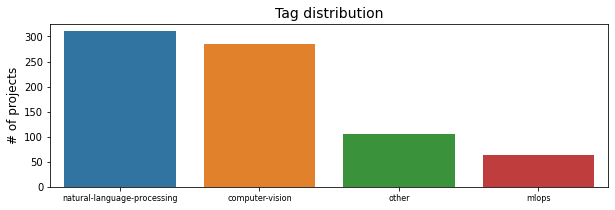

In [19]:
tags, tag_counts = zip(*tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()


In [21]:
tag = 'computer-vision'
plt.figure(figsize=(10,5))
subset = data[data.tag==tag]
text = subset.description.values
cloud = WordCloud(
    stopwords = STOPWORDS, background_color='black',
    collocations=False,width=500,height=300).generate(" ".join(text))
plt.axis('off')
plt.imshow(cloud)
    
    

ValueError: Only supported for TrueType fonts

<Figure size 720x216 with 0 Axes>

# Preprocessing

In [24]:
import json 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

## Simple Feature Engineering 

In [25]:
data['text'] = data.title + " " + data.description

## Cleaning

In [26]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\USER/nltk_data'
    - 'C:\\Users\\USER\\.conda\\envs\\torch\\nltk_data'
    - 'C:\\Users\\USER\\.conda\\envs\\torch\\share\\nltk_data'
    - 'C:\\Users\\USER\\.conda\\envs\\torch\\lib\\nltk_data'
    - 'C:\\Users\\USER\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [29]:
STOPWORDS = stopwords.words('english')

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\USER/nltk_data'
    - 'C:\\Users\\USER\\.conda\\envs\\torch\\nltk_data'
    - 'C:\\Users\\USER\\.conda\\envs\\torch\\share\\nltk_data'
    - 'C:\\Users\\USER\\.conda\\envs\\torch\\lib\\nltk_data'
    - 'C:\\Users\\USER\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [28]:
def clean_text(text,stopwords=STOPWORDS):
    #lower all text 
    text = text.lower()
    
    #remove stopwords with regex 
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('',text)
    
    #dealing with spacing and filters 
    
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text 
    

In [ ]:
original_data = data.copy()
data.text = data.text.apply(clean_text)
print(f"{original_data.text.values[0]}\n{data.text.values[0]}")

In [30]:
data = data.drop(columns=['id','created_on','title','description',],errors='ignore')
data = data.dropna(subset=['tag'])
data = data[['text','tag']] 
data.head()

,text,tag
0,Comparison between YOLO and RCNN on real world...,computer-vision
1,"Show, Infer & Tell: Contextual Inference for C...",computer-vision
2,Awesome Graph Classification A collection of i...,other
3,Awesome Monte Carlo Tree Search A curated list...,other
4,"AttentionWalk A PyTorch Implementation of ""Wat...",other


## Encoding

In [31]:
#encoding labels into unique indices 
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag:i for i,tag in enumerate(tags)}
class_to_index

{'natural-language-processing': 0,
 'other': 1,
 'computer-vision': 2,
 'mlops': 3}

In [33]:
data['tag'] = data['tag'].map(class_to_index)
data.head()

,text,tag
0,Comparison between YOLO and RCNN on real world...,2
1,"Show, Infer & Tell: Contextual Inference for C...",2
2,Awesome Graph Classification A collection of i...,1
3,Awesome Monte Carlo Tree Search A curated list...,1
4,"AttentionWalk A PyTorch Implementation of ""Wat...",1


In [34]:
# a decoder for decoding our predictions back to text 
def decode(pred,index_to_class):
    return [index_to_class[pred] for pred in pred]

In [36]:
index_to_class = {j:i for i,j in class_to_index.items()}

In [38]:
decode(data.head()['tag'].values,index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [40]:
#encode input text with tokenizers 
from transformers import BertTokenizer 

In [42]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

SSLError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /allenai/scibert_scivocab_uncased/resolve/main/vocab.txt (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))

In [43]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    inputs = tokenizer(batch['text'].tolist(), return_tensors='np',padding='longest')
    return dict(ids = inputs.input_ids,masks = inputs.attention_masks,targets=np.array(batch['tag']))


In [44]:
# we could modularize all of our preprocessing code into a single function 
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs